Code below gathers the data incrementally, saving it to csv on the fly so we can prevent timeout

In [1]:
import wikipedia
import random
import pandas as pd
import time
import os

def fetch_links(category):
    try:
        return wikipedia.page(category, auto_suggest=False).links
    except wikipedia.exceptions.DisambiguationError:
        return []
    except wikipedia.exceptions.PageError:
        return []

def fetch_article_data(title, category):
    try:
        page = wikipedia.page(title)
        return {
            "title": title,
            "summary": page.summary,
            "category": category,
            "content": page.content
        }
    except wikipedia.exceptions.DisambiguationError:
        return None
    except wikipedia.exceptions.PageError:
        return None

def random_data(num, categories, output_file,just_data_from_csv):
    wikipedia.set_lang("en")
    data = []
    visited_links = set()
    category_nums = { }
    for category in categories:
        category_nums[category] = 0

    if os.path.exists(output_file):
        existing_data = pd.read_csv(output_file)
        data.extend(existing_data.to_dict('records'))
        visited_links.update(existing_data['title'])
        database_categories = set(existing_data['category'].values)

        for category in database_categories:
            category_nums[category] = existing_data.loc[existing_data['category'] == category].count()['category']


    if not just_data_from_csv:
        for category in categories:
            links = fetch_links(category)
            print(category, len(links),"links available")
            random.shuffle(links)
            articles_in_category = category_nums[category]
            print("Entries in category already in database",category,":",articles_in_category)

            for link in links:
                if articles_in_category >= num:
                    break
                
                if link not in visited_links:
                    visited_links.add(link)
                    article_data = fetch_article_data(link, category)
                    if article_data:
                        data.append(article_data)
                        articles_in_category += 1
                        # Save to file after every iteration
                        pd.DataFrame(data).to_csv(output_file, index=False)
            print("Updated entries in category",category,":",articles_in_category)
    pandas_data = pd.DataFrame(data)

    return pandas_data


categories = [
    'Physics',
    'Chemistry',
    'Biology',
    'Mathematics'
]


num_articles_per_category = 500
output_file = 'random_data.csv'
random_dataset = random_data(num_articles_per_category, categories, output_file,True)
for category in categories:
    print(category,random_dataset.loc[random_dataset['category'] == category].count()['category'])
#print(random_dataset)


Physics 500
Chemistry 489
Biology 500
Mathematics 500


Text lemmatization and cleaning

In [2]:
import re
import contractions
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

def wrangle_text(text):
    soup = BeautifulSoup(text, 'html')
    text = soup.get_text()
    text = re.sub(r'https://\S+|www\.\S+', '', text)
    text = contractions.fix(text)
    return text

def prepare_data(text):
    text = wrangle_text(text)
    review_tokens = wordpunct_tokenize(text)
    review_tokens_filtered = [token.lower() for token in review_tokens if token.isalnum()]
    stopwords_en = stopwords.words('english')
    clean_review = [token for token in review_tokens_filtered if token not in stopwords_en]
    clean_review = [token for token in clean_review if token not in ['also']]
    wnl = WordNetLemmatizer()
    lemmatized_review = [wnl.lemmatize(el) for el in clean_review]
    return lemmatized_review


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adamousherovitch/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adamousherovitch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import gensim
from gensim import corpora, models

# content model

# Here you can either choose to train with summary or content of wikipedia page
c_processed_corpus = random_dataset['content'].apply(prepare_data)

c_dictionary = corpora.Dictionary(c_processed_corpus)

# c_dictionary.filter_extremes(no_below=20, no_above=0.5)

c_bow_corpus = [c_dictionary.doc2bow(doc) for doc in c_processed_corpus]
c_tfidf = models.TfidfModel(c_bow_corpus)
c_corpus_tfidf = c_tfidf[c_bow_corpus]

In [4]:
import gensim
from gensim import corpora, models

# summary model
s_processed_corpus = random_dataset['summary'].apply(prepare_data)

s_dictionary = corpora.Dictionary(s_processed_corpus)

# s_dictionary.filter_extremes(no_below=20, no_above=0.5)

s_bow_corpus = [s_dictionary.doc2bow(doc) for doc in s_processed_corpus]
s_tfidf = models.TfidfModel(s_bow_corpus)
s_corpus_tfidf = s_tfidf[s_bow_corpus]

/var/folders/6j/b_0507411fbfr6xghch8pd1m0000gn/T/ipykernel_66700/2495836372.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html')


In [5]:
s_lda_model = models.LdaModel(s_bow_corpus,id2word=s_dictionary, num_topics=4)
for idx, topic in s_lda_model.print_topics():
   print(f'Topic: {idx} \nWords: {topic}')
s_lda_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

Topic: 0 
Words: 0.008*"theory" + 0.005*"science" + 0.004*"chemical" + 0.003*"known" + 0.003*"cell" + 0.003*"used" + 0.003*"physic" + 0.003*"century" + 0.003*"field" + 0.003*"energy"
Topic: 1 
Words: 0.005*"field" + 0.005*"chemical" + 0.005*"science" + 0.005*"theory" + 0.004*"system" + 0.004*"one" + 0.003*"used" + 0.003*"university" + 0.003*"chemistry" + 0.003*"may"
Topic: 2 
Words: 0.005*"cell" + 0.005*"system" + 0.005*"used" + 0.005*"science" + 0.004*"one" + 0.004*"energy" + 0.004*"number" + 0.004*"field" + 0.004*"chemistry" + 0.004*"called"
Topic: 3 
Words: 0.005*"number" + 0.005*"physic" + 0.005*"one" + 0.004*"theory" + 0.004*"system" + 0.004*"study" + 0.004*"energy" + 0.004*"electron" + 0.004*"atom" + 0.004*"field"


[(0,
  '0.008*"theory" + 0.005*"science" + 0.004*"chemical" + 0.003*"known" + 0.003*"cell" + 0.003*"used" + 0.003*"physic" + 0.003*"century" + 0.003*"field" + 0.003*"energy"'),
 (1,
  '0.005*"field" + 0.005*"chemical" + 0.005*"science" + 0.005*"theory" + 0.004*"system" + 0.004*"one" + 0.003*"used" + 0.003*"university" + 0.003*"chemistry" + 0.003*"may"'),
 (2,
  '0.005*"cell" + 0.005*"system" + 0.005*"used" + 0.005*"science" + 0.004*"one" + 0.004*"energy" + 0.004*"number" + 0.004*"field" + 0.004*"chemistry" + 0.004*"called"'),
 (3,
  '0.005*"number" + 0.005*"physic" + 0.005*"one" + 0.004*"theory" + 0.004*"system" + 0.004*"study" + 0.004*"energy" + 0.004*"electron" + 0.004*"atom" + 0.004*"field"')]

In [6]:
s_document_topic_distributions = [s_lda_model[doc] for doc in s_bow_corpus]

s_document_vectors = []
for doc_topics in s_document_topic_distributions:
    vector = [0] * s_lda_model.num_topics
    for topic_id, prob in doc_topics:
        vector[topic_id] = prob
    s_document_vectors.append(vector)

In [8]:
c_lda_model = models.LdaModel(c_bow_corpus,id2word=c_dictionary, num_topics=4)
for idx, topic in c_lda_model.print_topics():
   print(f'Topic: {idx} \nWords: {topic}')
c_lda_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

Topic: 0 
Words: 0.004*"1" + 0.004*"one" + 0.004*"number" + 0.004*"displaystyle" + 0.003*"cell" + 0.003*"two" + 0.003*"example" + 0.003*"field" + 0.003*"theory" + 0.003*"2"
Topic: 1 
Words: 0.006*"displaystyle" + 0.006*"1" + 0.006*"2" + 0.004*"one" + 0.004*"theory" + 0.004*"x" + 0.003*"time" + 0.003*"used" + 0.003*"two" + 0.003*"0"
Topic: 2 
Words: 0.004*"one" + 0.003*"system" + 0.003*"used" + 0.003*"first" + 0.003*"energy" + 0.003*"two" + 0.003*"2" + 0.003*"number" + 0.003*"1" + 0.002*"theory"
Topic: 3 
Words: 0.005*"2" + 0.004*"theory" + 0.004*"1" + 0.004*"one" + 0.003*"time" + 0.003*"used" + 0.003*"n" + 0.003*"system" + 0.003*"x" + 0.003*"0"


[(0,
  '0.004*"1" + 0.004*"one" + 0.004*"number" + 0.004*"displaystyle" + 0.003*"cell" + 0.003*"two" + 0.003*"example" + 0.003*"field" + 0.003*"theory" + 0.003*"2"'),
 (1,
  '0.006*"displaystyle" + 0.006*"1" + 0.006*"2" + 0.004*"one" + 0.004*"theory" + 0.004*"x" + 0.003*"time" + 0.003*"used" + 0.003*"two" + 0.003*"0"'),
 (2,
  '0.004*"one" + 0.003*"system" + 0.003*"used" + 0.003*"first" + 0.003*"energy" + 0.003*"two" + 0.003*"2" + 0.003*"number" + 0.003*"1" + 0.002*"theory"'),
 (3,
  '0.005*"2" + 0.004*"theory" + 0.004*"1" + 0.004*"one" + 0.003*"time" + 0.003*"used" + 0.003*"n" + 0.003*"system" + 0.003*"x" + 0.003*"0"')]

In [9]:
c_document_topic_distributions = [c_lda_model[doc] for doc in c_bow_corpus]

c_document_vectors = []
for doc_topics in c_document_topic_distributions:
    vector = [0] * c_lda_model.num_topics
    for topic_id, prob in doc_topics:
        vector[topic_id] = prob
    c_document_vectors.append(vector)

In [10]:
s_assigned_topics = []

for doc in s_processed_corpus:
    s_bow_vector = s_dictionary.doc2bow(doc)
    s_topic_distribution = s_lda_model.get_document_topics(s_bow_vector)
    s_dominant_topic = max(s_topic_distribution, key=lambda item: item[1])[0]
    s_assigned_topics.append(s_dominant_topic)

In [11]:
c_assigned_topics = []

for doc in c_processed_corpus:
    c_bow_vector = c_dictionary.doc2bow(doc)
    c_topic_distribution = c_lda_model.get_document_topics(c_bow_vector)
    c_dominant_topic = max(c_topic_distribution, key=lambda item: item[1])[0]
    c_assigned_topics.append(c_dominant_topic)

In [ ]:
dic = {"Physics": {1:0, 2:0, 3:0, 0:0}, "Mathematics": {1:0, 2:0, 3:0, 0:0},
        "Biology": {1:0, 2:0, 3:0, 0:0}, "Chemistry": {1:0, 2:0, 3:0, 0:0}}
for i in range(len(s_assigned_topics)):
    dic[random_dataset["category"][i]][s_assigned_topics[i]] += 1
for category, nested_dict in dic.items():
    max_key = max(nested_dict, key=nested_dict.get)
    max_value = nested_dict[max_key]
    total_sum = sum(nested_dict.values())
    percent = (max_value / total_sum) * 100
    print(f"{category} : {max_key} "
          f"with {percent:.2f}% accuracy.")

Physics : 0 with 36.80% accuracy.
Mathematics : 2 with 31.80% accuracy.
Biology : 1 with 33.20% accuracy.
Chemistry : 1 with 36.61% accuracy.


In [ ]:
dic = {"Physics": {1:0, 2:0, 3:0, 0:0}, "Mathematics": {1:0, 2:0, 3:0, 0:0},
        "Biology": {1:0, 2:0, 3:0, 0:0}, "Chemistry": {1:0, 2:0, 3:0, 0:0}}
for i in range(len(c_assigned_topics)):
    dic[random_dataset["category"][i]][c_assigned_topics[i]] += 1
for category, nested_dict in dic.items():
    max_key = max(nested_dict, key=nested_dict.get)
    max_value = nested_dict[max_key]
    total_sum = sum(nested_dict.values())
    percent = (max_value / total_sum) * 100
    print(f"{category} : {max_key} "
          f"with {percent:.2f}% accuracy.")

Physics : 0 with 36.80% accuracy.
Mathematics : 1 with 45.40% accuracy.
Biology : 0 with 53.80% accuracy.
Chemistry : 3 with 45.81% accuracy.


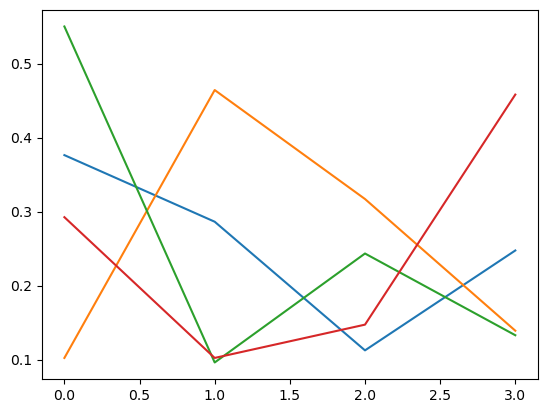

In [ ]:
import matplotlib.pyplot as plt
for cat in dic:
    plt.plot(range(4),[dic[cat][i]/total_sum for i in range(4)])

In [ ]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

s_vis_data = gensimvis.prepare(s_lda_model, s_bow_corpus, s_dictionary)
pyLDAvis.display(s_vis_data)

/Users/adamousherovitch/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

c_vis_data = gensimvis.prepare(c_lda_model, c_bow_corpus, c_dictionary)
pyLDAvis.display(c_vis_data)

/Users/adamousherovitch/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
s_word2vec_model = models.Word2Vec(s_processed_corpus, vector_size=100, window=5, min_count=1, workers=4)


In [ ]:
c_word2vec_model = models.Word2Vec(c_processed_corpus, vector_size=100, window=5, min_count=1, workers=4)


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
s_tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(s_processed_corpus)]
s_doc2vec_model = models.Doc2Vec(s_tagged_data, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
c_tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(c_processed_corpus)]
c_doc2vec_model = models.Doc2Vec(c_tagged_data, vector_size=100, window=5, min_count=1, workers=4)

**The Blobs**

In [ ]:
# from sklearn.manifold import TSNE
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# word_vectors = s_word2vec_model.wv
# words = list(word_vectors.key_to_index.keys())
# word_vectors_matrix = np.array([word_vectors[word] for word in words])

# tsne = TSNE(n_components=3, random_state=42)
# word_vectors_tsne = tsne.fit_transform(word_vectors_matrix)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], word_vectors_tsne[:, 2], marker='.')
# for i, word in enumerate(words):
#     ax.text(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1], word_vectors_tsne[i, 2], word, fontsize=8)
# plt.show()


In [ ]:
# word_vectors = s_word2vec_model.wv
# words = list(word_vectors.key_to_index.keys())
# word_vectors_matrix = np.array([word_vectors[word] for word in words])
# tsne = TSNE(n_components=2, random_state=42)
# word_vectors_tsne = tsne.fit_transform(word_vectors_matrix)

# plt.figure(figsize=(10, 8))
# plt.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], marker='.')
# for i, word in enumerate(words):
#     plt.annotate(word, xy=(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1]), fontsize=8)
# plt.show()


**Dumb/fun idea**

In [ ]:
# this is dumb but i couldn't think of better tbh
import numpy as np
s_word2vec_corpus = []
for doc in s_processed_corpus:
    doc_vector = np.zeros((100,))
    num_words = 0
    for word in doc:
        if word in s_word2vec_model.wv:
            doc_vector += s_word2vec_model.wv[word]
            num_words += 1
    if num_words > 0:
        doc_vector /= num_words
    s_word2vec_corpus.append(doc_vector)

In [ ]:
# this is dumb but i couldn't think of better tbh x2

c_word2vec_corpus = []
for doc in c_processed_corpus:
    doc_vector = np.zeros((100,))
    num_words = 0
    for word in doc:
        if word in c_word2vec_model.wv:
            doc_vector += c_word2vec_model.wv[word]
            num_words += 1
    if num_words > 0:
        doc_vector /= num_words
    c_word2vec_corpus.append(doc_vector)

In [ ]:
## enter word, recieve the top 10 similarities

import dash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
from gensim.models import Word2Vec

def get_similar_words(word, topn=10):
    similar_words = c_word2vec_model.wv.most_similar(positive=[word], topn=topn)
    return [word[0] for word in similar_words]

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Input(id='input-word', type='text', value='enter word'),
    html.Button('Submit', id='submit-val', n_clicks=0),
    html.Div(id='output-container-button', children='Enter a word and press submit')
])

@app.callback(
    Output('output-container-button', 'children'),
    [Input('submit-val', 'n_clicks')],
    [Input('input-word', 'value')]
)
def update_output(n_clicks, value):
    if n_clicks > 0:
        similar_words = get_similar_words(value, topn=10)
        return html.Div([
            html.P(f"Similar words to '{value}':"),
            html.Ul([html.Li(word) for word in similar_words])
        ])

if __name__ == '__main__':
    app.run_server(debug=True)


In [ ]:
# graph visualization of top 10 words

# not working yet

import dash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
import plotly.graph_objs as go
from gensim.models import Word2Vec
import networkx as nx


# Get top 50 similar words for a given word
def get_similar_words(word, topn=50):
    similar_words = c_word2vec_model.wv.most_similar(positive=[word], topn=topn)
    return similar_words

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Input(id='input-word', type='text', value='enter word'),
    html.Button('Submit', id='submit-val', n_clicks=0),
    dcc.Graph(id='word-similarity-graph'),
])

@app.callback(
    Output('word-similarity-graph', 'figure'),
    [Input('submit-val', 'n_clicks')],
    [Input('input-word', 'value')]
)
def update_graph(n_clicks, value):
    if n_clicks > 0:
        similar_words = get_similar_words(value, topn=10)
        
        # Create a network graph
        G = nx.Graph()
        G.add_node(value)
        for word, sim in similar_words:
            G.add_node(word)
            G.add_edge(value, word, weight=sim)
        
        # Position nodes using spring layout
        pos = nx.spring_layout(G)
        
        # Create edge trace
        edge_trace = go.Scatter(
            x=[],
            y=[],
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines')
        
        # Add edges to edge trace
        for edge in G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_trace['x'] += tuple([x0, x1, None])
            edge_trace['y'] += tuple([y0, y1, None])
        
        # Create node trace
        node_trace = go.Scatter(
            x=[],
            y=[],
            text=[],
            mode='markers',
            hoverinfo='text',
            marker=dict(
                showscale=True,
                colorscale='YlGnBu',
                reversescale=True,
                color=[],
                size=10,
                colorbar=dict(
                    thickness=15,
                    title='Node Connections',
                    xanchor='left',
                    titleside='right'
                ),
                line=dict(width=2)))
        
        # Add nodes to node trace
        for node in G.nodes():
            x, y = pos[node]
            node_trace['x'] += tuple([x])
            node_trace['y'] += tuple([y])
            node_trace['text'] += tuple([node])
        
        # Color nodes by their degree
        node_adjacencies = []
        node_text = []
        for node, adjacencies in enumerate(G.adjacency()):
            node_adjacencies.append(len(adjacencies[1]))
            node_text.append('# of connections: '+str(len(adjacencies[1])))
        node_trace['marker']['color'] = node_adjacencies
        node_trace['text'] = node_text
        
        # Create figure
        fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            title='Word Similarity Graph',
                            titlefont=dict(size=16),
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=20, l=5, r=5, t=40),
                            annotations=[dict(
                                text="",
                                showarrow=False,
                                xref="paper", yref="paper",
                                x=0.005, y=-0.002)],
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
        
        return fig

if __name__ == '__main__':
    app.run_server(debug=True)


**Nearest words graphing**

In [ ]:
# # CLEAN working tsne simmilarity plot
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# def tsnescatterplot(model, word, list_names):
#     arrays = np.empty((0, model.vector_size), dtype='f')
#     word_labels = [word]
#     color_list  = ['red']

#     # adds the vector of the query word
#     arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
#     # gets list of most similar words
#     close_words = model.wv.most_similar([word])
    
#     # adds the vector for each of the closest words to the array
#     for wrd_score in close_words:
#         wrd_vector = model.wv.__getitem__([wrd_score[0]])
#         word_labels.append(wrd_score[0])
#         color_list.append('blue')
#         arrays = np.append(arrays, wrd_vector, axis=0)
    
#     # adds the vector for each of the words from list_names to the array
#     for wrd in list_names:
#         wrd_vector = model.wv.__getitem__([wrd])
#         word_labels.append(wrd)
#         color_list.append('green')
#         arrays = np.append(arrays, wrd_vector, axis=0)
        
#     # Reduces the dimensionality using PCA
#     pca = PCA(n_components=min(model.vector_size, arrays.shape[0]), svd_solver='full')
#     arrays_pca = pca.fit_transform(arrays)
    
#     # Finds t-SNE coordinates for 2 dimensions
#     tsne = TSNE(n_components=2, random_state=0, perplexity=min(15, arrays.shape[0]-1))
#     Y = tsne.fit_transform(arrays_pca)
    
#     # Sets everything up to plot
#     df = pd.DataFrame({'x': [x for x in Y[:, 0]],
#                        'y': [y for y in Y[:, 1]],
#                        'words': word_labels,
#                        'color': color_list})
    
#     fig, _ = plt.subplots()
#     fig.set_size_inches(9, 9)
    
#     # Basic plot
#     p1 = sns.regplot(data=df,
#                      x="x",
#                      y="y",
#                      fit_reg=False,
#                      marker="o",
#                      scatter_kws={'s': 40,
#                                   'facecolors': df['color']
#                                  }
#                     )
    
#     # Adds annotations one by one with a loop
#     for line in range(0, df.shape[0]):
#          p1.text(df["x"][line],
#                  df['y'][line],
#                  '  ' + df["words"][line].title(),
#                  horizontalalignment='left',
#                  verticalalignment='bottom', size='medium',
#                  color=df['color'][line],
#                  weight='normal'
#                 ).set_size(15)

    
#     plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
#     plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
#     plt.title('t-SNE visualization for {}'.format(word.title()))

# # you can add random words to graph, or set other_words_to_plot to [] so nothing else than simmillar words show up
# # num_of_random_words = 5
# # randoms = np.random.choice(list(model.wv.key_to_index.keys()), size=num_of_random_words, replace=False)
# # other_words_to_plot = ['jesus', 'pig', 'solution']
# other_words_to_plot = []
# tsnescatterplot(c_word2vec_model, 'lemma', other_words_to_plot)
# tsnescatterplot(c_word2vec_model, 'hydrogen', other_words_to_plot)


In [ ]:
from gensim.matutils import corpus2dense, corpus2csc
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

s_corpus_tfidf_sparse = corpus2csc(s_corpus_tfidf).T
s_corpus_bow_sparse = corpus2csc(s_bow_corpus).T
s_corpus_word2vec_sparse = csr_matrix(s_word2vec_corpus)
s_corpus_doc2vec = [s_doc2vec_model.dv[tag] for tag in s_doc2vec_model.dv.index_to_key]

svd = TruncatedSVD(n_components=10, random_state=42)
s_corpus_tfidf_svd = svd.fit_transform(s_corpus_tfidf_sparse)
s_corpus_bow_svd = svd.fit_transform(s_corpus_bow_sparse)
s_corpus_word2vec_svd = svd.fit_transform(s_word2vec_corpus)
s_corpus_doc2vec_svd = svd.fit_transform(s_corpus_doc2vec)

Y = random_dataset['category']

In [ ]:
from gensim.matutils import corpus2dense, corpus2csc
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

c_corpus_tfidf_sparse = corpus2csc(c_corpus_tfidf).T
c_corpus_bow_sparse = corpus2csc(c_bow_corpus).T
c_corpus_word2vec_sparse = csr_matrix(c_word2vec_corpus)
c_corpus_doc2vec = [c_doc2vec_model.dv[tag] for tag in c_doc2vec_model.dv.index_to_key]

svd = TruncatedSVD(n_components=10, random_state=42)
c_corpus_tfidf_svd = svd.fit_transform(c_corpus_tfidf_sparse)
c_corpus_bow_svd = svd.fit_transform(c_corpus_bow_sparse)
c_corpus_word2vec_svd = svd.fit_transform(c_word2vec_corpus)
c_corpus_doc2vec_svd = svd.fit_transform(c_corpus_doc2vec)

Y = random_dataset['category']


***MACHINE LEARNING SECTION***

*word2vec*

In [ ]:
# Using word2vec normal summary

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(s_corpus_word2vec_sparse, Y, test_size=0.3, random_state=42)


param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf'], 'degree': [1, 2, 3]}

svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

s_best_svm = SVC(**best_params)
s_best_svm.fit(X_train, y_train)

y_pred = s_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

s_class_report_word2vec_normal = classification_report(y_test, y_pred, output_dict=True)


Best hyperparameters: {'C': 10, 'degree': 2, 'kernel': 'linear'}
Accuracy: 0.7169179229480737


In [ ]:
# using word2vec extracted summary

X_train, X_test, y_train, y_test = train_test_split(s_corpus_word2vec_svd, Y, test_size=0.3, random_state=42)
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

s_best_svm = SVC(**best_params)
s_best_svm.fit(X_train, y_train)

y_pred = s_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


s_class_report_word2vec_extracted = classification_report(y_test, y_pred, output_dict=True)


Best hyperparameters: {'C': 10, 'degree': 2, 'kernel': 'linear'}
Accuracy: 0.7085427135678392


In [ ]:
# Using word2vec normal content

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(c_corpus_word2vec_sparse, Y, test_size=0.3, random_state=42)
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

c_best_svm = SVC(**best_params)
c_best_svm.fit(X_train, y_train)

y_pred = c_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


c_class_report_word2vec_normal = classification_report(y_test, y_pred, output_dict=True)

Best hyperparameters: {'C': 10, 'degree': 2, 'kernel': 'poly'}
Accuracy: 0.7621440536013401


In [ ]:
# using word2vec extracted content 

X_train, X_test, y_train, y_test = train_test_split(c_corpus_word2vec_svd, Y, test_size=0.3, random_state=42)
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

c_best_svm = SVC(**best_params)
c_best_svm.fit(X_train, y_train)

y_pred = c_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

c_class_report_word2vec_extracted = classification_report(y_test, y_pred, output_dict=True)


Best hyperparameters: {'C': 10, 'degree': 2, 'kernel': 'poly'}
Accuracy: 0.7504187604690117


*LDA*

In [ ]:
# using LDA summary

X_train, X_test, y_train, y_test = train_test_split(s_document_vectors, Y, test_size=0.3, random_state=42)
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

s_best_svm = SVC(**best_params)
s_best_svm.fit(X_train, y_train)

y_pred = s_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


s_class_report_LDA = classification_report(y_test, y_pred, output_dict=True)


Best hyperparameters: {'C': 1, 'degree': 2, 'kernel': 'poly'}
Accuracy: 0.34840871021775544


In [ ]:
# using LDA content

X_train, X_test, y_train, y_test = train_test_split(c_document_vectors, Y, test_size=0.3, random_state=42)
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

c_best_svm = SVC(**best_params)
c_best_svm.fit(X_train, y_train)

y_pred = c_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


c_class_report_LDA = classification_report(y_test, y_pred, output_dict=True)


Best hyperparameters: {'C': 0.1, 'degree': 3, 'kernel': 'poly'}
Accuracy: 0.4824120603015075


*doc2vec*

In [ ]:
# using doc2vec normal summary

X_train, X_test, y_train, y_test = train_test_split(s_corpus_doc2vec, Y, test_size=0.3, random_state=42)
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

s_best_svm = SVC(**best_params)
s_best_svm.fit(X_train, y_train)

y_pred = s_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


s_class_report_doc2vec_normal = classification_report(y_test, y_pred, output_dict=True)

Best hyperparameters: {'C': 10, 'degree': 2, 'kernel': 'linear'}
Accuracy: 0.6934673366834171


In [ ]:
# using doc2vec extracted summary

X_train, X_test, y_train, y_test = train_test_split(s_corpus_doc2vec_svd, Y, test_size=0.3, random_state=42)
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

s_best_svm = SVC(**best_params)
s_best_svm.fit(X_train, y_train)

y_pred = s_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


s_class_report_doc2vec_extracted = classification_report(y_test, y_pred, output_dict=True)

Best hyperparameters: {'C': 10, 'degree': 2, 'kernel': 'linear'}
Accuracy: 0.6850921273031826


In [ ]:
# using doc2vec normal content

X_train, X_test, y_train, y_test = train_test_split(c_corpus_doc2vec, Y, test_size=0.3, random_state=42)
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

c_best_svm = SVC(**best_params)
c_best_svm.fit(X_train, y_train)

y_pred = c_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


c_class_report_doc2vec_normal = classification_report(y_test, y_pred, output_dict=True)

Best hyperparameters: {'C': 1, 'degree': 2, 'kernel': 'poly'}
Accuracy: 0.6917922948073701


In [ ]:
# using doc2vec extracted content

X_train, X_test, y_train, y_test = train_test_split(c_corpus_doc2vec_svd, Y, test_size=0.3, random_state=42)
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

c_best_svm = SVC(**best_params)
c_best_svm.fit(X_train, y_train)

y_pred = c_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


c_class_report_doc2vec_extracted = classification_report(y_test, y_pred, output_dict=True)

Best hyperparameters: {'C': 0.1, 'degree': 2, 'kernel': 'linear'}
Accuracy: 0.6666666666666666


*TFIDF*

In [ ]:
# using summary, # TF_IDF

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Added a label encoder, because the r2 didn't seem to work when training
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y = lb.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(csr_matrix(s_corpus_tfidf_sparse), y, test_size=0.3, random_state=42)
# print(len(y_test))
# print(len(y_train))
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

s_best_svm = SVC(**best_params)

s_best_svm.fit(X_train, y_train)

y_pred = s_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


s_class_report_tfidf_normal = classification_report(y_test, y_pred, output_dict=True)


Best hyperparameters: {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.7470686767169179


In [ ]:
# using summary, extracted TFIDF

lb = LabelEncoder()
y = lb.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(csr_matrix(s_corpus_tfidf_svd), y, test_size=0.3, random_state=42)
# print(len(y_test))
# print(len(y_train))
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

s_best_svm = SVC(**best_params)

s_best_svm.fit(X_train, y_train)

y_pred = s_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Calculate classification report


s_class_report_tfidf_extracted = classification_report(y_test, y_pred, output_dict=True)


Best hyperparameters: {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.7604690117252931


In [ ]:
# using content, # TF_IDF normal

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Added a label encoder, because the r2 didn't seem to work when training
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y = lb.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(csr_matrix(c_corpus_tfidf_sparse), y, test_size=0.3, random_state=42)
# print(len(y_test))
# print(len(y_train))
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

c_best_svm = SVC(**best_params)

c_best_svm.fit(X_train, y_train)

y_pred = c_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# Calculate classification report
c_class_report_tfidf_normal = classification_report(y_test, y_pred, output_dict=True)


Best hyperparameters: {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.7638190954773869


In [ ]:
# using extracted TFIDF content

lb = LabelEncoder()
y = lb.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(csr_matrix(c_corpus_tfidf_svd), y, test_size=0.3, random_state=42)
# print(len(y_test))
# print(len(y_train))
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

c_best_svm = SVC(**best_params)

c_best_svm.fit(X_train, y_train)

y_pred = c_best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Calculate classification report
c_class_report_tfidf_extracted = classification_report(y_test, y_pred, output_dict=True)


Best hyperparameters: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.7587939698492462


*BOW*

In [ ]:
# using summary, # BOW
from scipy.sparse import hstack

X_train, X_test, y_train, y_test = train_test_split(csr_matrix(s_corpus_bow_sparse), y, test_size=0.3, random_state=42)
# print(len(y_test))
# print(len(y_train))
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

s_best_svm = SVC(**best_params)

s_best_svm.fit(X_train, y_train)

y_pred_bow = s_best_svm.predict(X_test)

s_accuracy = accuracy_score(y_test, y_pred_bow)
print("Accuracy:", accuracy)


s_class_report_bow_normal= classification_report(y_test, y_pred_bow, output_dict=True)


Best hyperparameters: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.7587939698492462


In [ ]:
# using summary, # extracted BOW

X_train, X_test, y_train, y_test = train_test_split(csr_matrix(s_corpus_bow_svd), y, test_size=0.3, random_state=42)
# print(len(y_test))
# print(len(y_train))
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

s_best_svm = SVC(**best_params)

s_best_svm.fit(X_train, y_train)

y_pred_bow = s_best_svm.predict(X_test)

s_accuracy = accuracy_score(y_test, y_pred_bow)
print("Accuracy:", accuracy)


s_class_report_bow_extracted = classification_report(y_test, y_pred_bow, output_dict=True)


Best hyperparameters: {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.7587939698492462


In [ ]:
# using normal, # BOW content
from scipy.sparse import hstack

X_train, X_test, y_train, y_test = train_test_split(csr_matrix(c_corpus_bow_sparse), y, test_size=0.3, random_state=42)
# print(len(y_test))
# print(len(y_train))
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

c_best_svm = SVC(**best_params)

c_best_svm.fit(X_train, y_train)

y_pred_bow = c_best_svm.predict(X_test)

c_accuracy = accuracy_score(y_test, y_pred_bow)
print("Accuracy:", c_accuracy)

c_class_report_bow_normal = classification_report(y_test, y_pred_bow, output_dict=True)

Best hyperparameters: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.7370184254606366


In [ ]:
# using # extracted BOW content

X_train, X_test, y_train, y_test = train_test_split(csr_matrix(s_corpus_bow_svd), y, test_size=0.3, random_state=42)
# print(len(y_test))
# print(len(y_train))
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

c_best_svm = SVC(**best_params)

c_best_svm.fit(X_train, y_train)

y_pred_bow = c_best_svm.predict(X_test)

c_accuracy = accuracy_score(y_test, y_pred_bow)
print("Accuracy:", accuracy)


c_class_report_bow_extracted = classification_report(y_test, y_pred_bow, output_dict=True)

Best hyperparameters: {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.7587939698492462


In [ ]:
## get all the dfs
df_s_class_report_word2vec = pd.DataFrame(s_class_report_word2vec_normal).transpose()
df_s_class_report_word2vec_ex = pd.DataFrame(s_class_report_word2vec_extracted).transpose()

df_s_class_report_LDA = pd.DataFrame(s_class_report_LDA).transpose()

df_s_class_report_doc2vec = pd.DataFrame(s_class_report_doc2vec_normal).transpose()
df_s_class_report_doc2vec_ex = pd.DataFrame(s_class_report_doc2vec_extracted).transpose()

df_s_class_report_tfidf = pd.DataFrame(s_class_report_tfidf_normal).transpose()
df_s_class_report_tfidf_ex = pd.DataFrame(s_class_report_tfidf_extracted).transpose()

df_s_class_report_bow = pd.DataFrame(s_class_report_bow_normal).transpose()
df_s_class_report_bow_ex = pd.DataFrame(s_class_report_bow_extracted).transpose()



df_c_class_report_word2vec = pd.DataFrame(c_class_report_word2vec_normal).transpose()
df_c_class_report_word2vec_ex = pd.DataFrame(c_class_report_word2vec_extracted).transpose()

df_c_class_report_LDA = pd.DataFrame(c_class_report_LDA).transpose()

df_c_class_report_doc2vec = pd.DataFrame(c_class_report_doc2vec_normal).transpose()
df_c_class_report_doc2vec_ex = pd.DataFrame(c_class_report_doc2vec_extracted).transpose()

df_c_class_report_tfidf = pd.DataFrame(c_class_report_tfidf_normal).transpose()
df_c_class_report_tfidf_ex = pd.DataFrame(c_class_report_tfidf_extracted).transpose()

df_c_class_report_bow = pd.DataFrame(c_class_report_bow_normal).transpose()
df_c_class_report_bow_ex = pd.DataFrame(c_class_report_bow_extracted).transpose()
print('gottem')


gottem


In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming y_pred contains the predicted labels and y_test contains the true labels

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Get unique category labels
labels = np.unique(Y)

class_report_df = df_s_class_report_bow
# Dash app
app = dash.Dash(__name__)

# Confusion Matrix Figure
fig_conf_matrix = px.imshow(conf_matrix, labels=dict(x="Predicted", y="True", color="Count"),
                             x=labels, y=labels)

import dash_table

# Classification Report Table
fig_class_report = html.Div(
    id='class-report-div',
    children=[
        html.H4("Classification Report"),
        dash_table.DataTable(
            id='class-report-table',
            columns=[{"name": i, "id": i} for i in class_report_df.columns],
            data=class_report_df.to_dict('records'),
            style_table={'height': '300px', 'overflowY': 'auto'}
        )
    ]
)

# Directions for navigating the figure
directions = html.Div([
    html.H4("Directions"),
    html.P("Use the mouse to hover over each cell to see the exact count of instances."),
    html.P("Click and drag to select a portion of the matrix to zoom in."),
    html.P("Double click to reset the zoom level."),
], id='directions')

# Button to hide/show directions
directions_button = html.Button('Hide Directions', id='directions-button', n_clicks=0)

# Dropdown options with category names and metrics
dropdown_options = [{'label': f"{col} ({label})", 'value': col} for col, label in zip(class_report_df.columns, labels)]

# Layout
app.layout = html.Div([
    html.H1("Document Classification Dashboard"),
    
    html.Div([
        html.Div([
            dcc.Graph(id='confusion-matrix', figure=fig_conf_matrix),
            directions,
            directions_button
        ], style={'width': '50%', 'display': 'inline-block'}),
        
        html.Div([
            dcc.RadioItems(
                id='report-type',
                options=[
                    {'label': 'Summary', 'value': 'summary'},
                    {'label': 'Content', 'value': 'content'}
                ],
                value='summary',  # Default value
                labelStyle={'display': 'block'}
            ),
            html.Div(id='report-container')
        ], style={'width': '50%', 'display': 'inline-block'}),
        
        
        html.Div([
    dcc.RadioItems(
        id='model-type',
        options=[
            {'label': 'TFIDF', 'value': 'tfidf'},
            {'label': 'BOW', 'value': 'bow'}
        ],
        value='tfidf',  # Default value
        labelStyle={'display': 'block'}
    ),
    dcc.Graph(id='model-performance')
    ]),


        
        html.Div([
            fig_class_report,
            dcc.Dropdown(
                id='class-dropdown',
                options=dropdown_options,
                value='precision',  # Default value
                style={'width': '100%'}
            )
        ], style={'width': '50%', 'display': 'inline-block'})
    ])
])

# Callback to update the classification report based on dropdown selection
@app.callback(
    Output('class-report-div', 'children'),
    [Input('class-dropdown', 'value')]
)
def update_class_report(metric):
    updated_class_report_df = class_report_df[[metric]]
    updated_fig_class_report = html.Div(
        id='class-report-div',
        children=[
            html.H4("Classification Report"),
            dash_table.DataTable(
                id='class-report-table',
                columns=[{"name": i, "id": i} for i in updated_class_report_df.columns],
                data=updated_class_report_df.to_dict('records'),
                style_table={'height': '300px', 'overflowY': 'auto'}
            )
        ]
    )
    return updated_fig_class_report

# Callback to hide/show directions
@app.callback(
    Output('directions', 'style'),
    [Input('directions-button', 'n_clicks')]
)
def toggle_directions(n_clicks):
    if n_clicks % 2 == 0:
        return {'display': 'block'}
    else:
        return {'display': 'none'}

if __name__ == '__main__':
    app.run_server(debug=True)

/Users/adamousherovitch/opt/anaconda3/lib/python3.8/site-packages/dash/_jupyter.py:28: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  _dash_comm = Comm(target_name="dash")
/Users/adamousherovitch/opt/anaconda3/lib/python3.8/site-packages/plotly/express/imshow_utils.py:24: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/var/folders/6j/b_0507411fbfr6xghch8pd1m0000gn/T/ipykernel_63536/675762345.py:24: UserWarning:


The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`



In [ ]:
class_report_df_1 = df_s_class_report_bow

class_report_df_2 = df_s_class_report_tfidf

In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go
import pandas as pd

# Define Dash app
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    html.H1("Document Classification Dashboard"),
    
    # Radio buttons for model type (TF-IDF or BOW)
    html.Div([
        dcc.RadioItems(
            id='model-type',
            options=[
                {'label': 'TF-IDF', 'value': 'tfidf'},
                {'label': 'BOW', 'value': 'bow'}
            ],
            value='tfidf',  # Default value
            labelStyle={'display': 'block'}
        ),
    ]),
    
    # Graph to display model performance
    html.Div([
        dcc.Graph(id='model-performance-graph'),
    ]),
])

# Callback to update the graph with model performance metrics
@app.callback(
    Output('model-performance-graph', 'figure'),
    [Input('model-type', 'value')]
)
def update_model_performance(model_type):
    # Filter the appropriate metrics based on the model type
    if model_type == 'tfidf':
        model_metrics = class_report_df_1.loc[['0', '1', '2', '3', 'accuracy', 'macro avg', 'weighted avg']]
    else:
        model_metrics = class_report_df_2.loc[['0', '1', '2', '3', 'accuracy', 'macro avg', 'weighted avg']] - .5
    
    # Create traces for precision, recall, and f1-score
    precision_trace = go.Bar(
        x=model_metrics.index,
        y=model_metrics['precision'],
        name='Precision'
    )
    recall_trace = go.Bar(
        x=model_metrics.index,
        y=model_metrics['recall'],
        name='Recall'
    )
    f1_score_trace = go.Bar(
        x=model_metrics.index,
        y=model_metrics['f1-score'],
        name='F1-Score'
    )
    
    # Create layout for the graph
    layout = go.Layout(
        title='Model Performance Metrics',
        barmode='group',
        xaxis=dict(title='Category'),
        yaxis=dict(title='Score'),
    )
    
    # Return the figure
    return {'data': [precision_trace, recall_trace, f1_score_trace], 'layout': layout}

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)

